## Setup

In [1]:
# Compatibility with Python 3
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 == 0.5, not 0

In [2]:
# Show figures inside the notebook
%matplotlib inline

In [3]:
import numpy as np  # the Python array package
import matplotlib.pyplot as plt  # the Python plotting package

There is a four-dimensional (X, Y, Z, t) BOLD image in the same directory as this notebook, called `ds107_sub012_t1r2.nii`.   Import the `nibabel` module, and load the image with nibabel to create an image object.  Turn off memory mapping with the load command.

In [4]:
# Load image object using nibabel, turning off memory mapping.
fname = 'ds107_sub012_t1r2.nii'
import nibabel as nib
img = nib.load(fname, mmap=False)

In the usual way get the array data from this image and show the image shape.

In [5]:
# Get image array data from image object
data = img.get_data()

Select the 10th volume (time index 9) from 4D image data array, by slicing over the last dimension.  What shape is it?

In [6]:
# Get the 10th volume and show shape
tenth_vol = data[..., 9]
tenth_vol.shape

(64, 64, 35)

Get the standard deviation across all voxels in this 3D volume:

In [7]:
# Standard deviation across all voxels for 10th volume
np.std(tenth_vol)

387.19281139947577

Loop over all volumes in the 4D image and store the standard deviation for each volume in a list.  Plot these to see if there are any volumes with particularly unusual standard deviation.

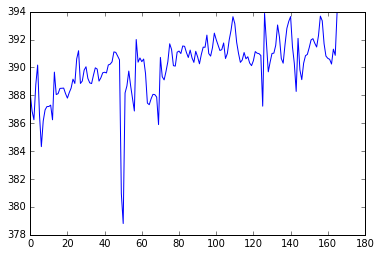

In [8]:
# Get standard deviation for each volume; then plot the values
stds = []
for i in range(data.shape[-1]):
    vol = data[..., i]
    stds.append(np.std(vol))
plt.plot(stds)

SPM uses a measure called "global signal" to give a very rough estimate of the average signal value within the brain.  The idea is that you need a threshold to select voxels with signal high enough to be inside the brain, and not in the air around the brain, which has very low (near 0) signal.

The algorithm goes like this.

* Get a single 3D volume V;
* Calculate the mean signal of the voxels in V; call that M;
* Make a threshold T where T = M / 8.
* Select all voxel values in V that are greater than T; call these values W;
* Return the mean of all values in W.

See [SPM global image signal](http://imaging.mrc-cbu.cam.ac.uk/imaging/PrinciplesStatistics#Global_image_signal).

In the SPM code, the algorithm is implemented in a MATLAB function called `spm_global`.  

I used the MATLAB script `get_global_signals.m` (in this directory) to run the `spm_global` MATLAB function on the volumes of `ds107_sub012_t1r2.nii`.  The script saved the SPM global values to a text file `global_signals.txt` in this directory.   The first four lines of the `global_signals.txt` file look like this:

```
376.53
375.75
375.26
376.01
```

Read these global values calculated by SPM into a list, and plot the values.

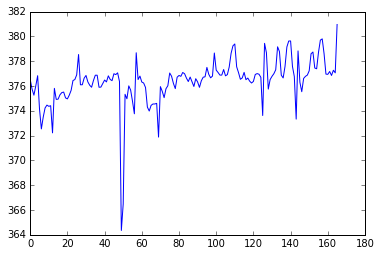

In [9]:
# Read global signal values calculated by SPM, and plot
global_signals = np.loadtxt('global_signals.txt')
plt.plot(global_signals)

Now implement the algorithm above to recalculate the SPM global signal for the first volume (volume index zero).  Hint: you will likely need to index using a boolean (mask) array.  Remember, the steps are:

* Get a single 3D volume V;
* Calculate the mean signal of the voxels in V; call that M;
* Make a threshold T where T = M / 8.
* Select all voxel values in V that are greater than T; call these values W;
* Get the mean of all values in W.

You should get the same value as SPM - the first value you read from `global_signals.txt`.

In [10]:
# Apply algorithm for SPM global calculation to first volume
vol = data[..., 0]
T = np.mean(vol)/ 8
msk = vol > T
W = vol[msk]
np.mean(W)

376.53382753187225

Make a function called `spm_global` that accepts a 3D array as input, and returns the global signal using the SPM algorithm.  Call that function on the first volume to show that it is working (as in `print(spm_global(data[:, :, :, 0]))`).

In [11]:
# Make a `spm_global` function that accepts a 3D array as input,
# and returns the global mean for the volume according to the SPM algorithm
def spm_global(vol):
    T = np.mean(vol) / 8
    return np.mean(vol[vol > T])

print(spm_global(data[:, :, :, 0]))

376.533827532


Make a function called `get_spm_globals` that accepts an image filename as an argument.  The function will load the image, get the array data for the image, use your new `spm_global` function calculate the global value for each volume, and return these values as a list.  Finally, show this is working by plotting the values for the `ds107_sub012_t1r2.nii` image with something like: 

```
all_globals = get_spm_globals('ds107_sub012_t1r2.nii')
plt.plot(all_globals)
```

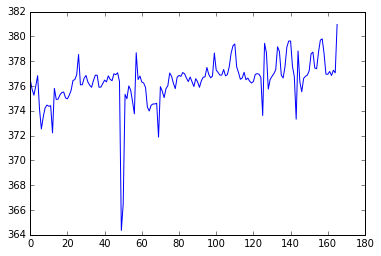

In [12]:
# Write a function `get_spm_globals` that returns the global values 
# for each volume
def get_spm_globals(fname):
    img = nib.load(fname)
    data = img.get_data()
    spm_vals = []
    for i in range(data.shape[-1]):
        vol = data[..., i]
        spm_vals.append(spm_global(vol))
    return spm_vals

all_globals = get_spm_globals('ds107_sub012_t1r2.nii')
plt.plot(all_globals)